In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm.notebook import tqdm
from GalPop import GalPop

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.27)


In [2]:
# Compile populations
sig_cube = fits.open(r"C:\Users\sikor\OneDrive\Desktop\benpy\FinalTry\Hyperion_interpolated_cube_sigma.fits")
sigs = np.array([2.0, 2.25] + list(np.arange(2.5,5.5,0.5)))
pk_path = r"C:\Users\sikor\OneDrive\Desktop\BigData\Hyperion\HyperionPeaks\\"
pk_sums = [f"peaks_sig{s}.dat" for s in sigs]

gps = [GalPop.loadFile(f'Final_GPs/MC_{n}.npy') for n in range(0,101)]

In [3]:
# Make SubPops

for _gid, g in tqdm(enumerate(gps), total=len(gps)):

    h_objs = np.logical_and((g.pks[2.25] == 1), (g.mags['IRAC'] <= 25.))


    s1 =  np.where((g.mags['IRAC']<=25.0) & (g.coords[:,2] >= 2.15) & (g.coords[:,2] <= 2.25))
    g.makeField("field1", [2.25, 4.0, 13.], pk_path, "peaks_sig2.25.dat", 'sig2.25_peaks', cosmo, s1)

    s2 =  np.where((g.mags['IRAC']<=25.0) & (g.coords[:,2] >= 2.8) & (g.coords[:,2] <= 2.9))
    g.makeField("field2", [2.25, 4.0, 13.], pk_path, "peaks_sig2.25.dat", 'sig2.25_peaks', cosmo, s2)

    g.subpops['field'] = np.logical_and(g.subpops['field1'], g.subpops['field2'])
    g.vols['field'] = g.subpops['field1'] + g.subpops['field2']


    
    for si, sigma in enumerate(sigs):
        g.subPop(f"o{sigma}", [sigma, np.inf], 13., [2.35, 2.7], pk_path, pk_sums[si], sig_cube, gal_sample=h_objs)


    g.subPop(f"23", [2.0, 3.0], 13., [2.35, 2.7], pk_path, "peaks_sig2.0.dat", sig_cube, gal_sample=h_objs)
    g.subPop(f"34", [3.0, 4.0], 13., [2.35, 2.7], pk_path, "peaks_sig3.0.dat", sig_cube, gal_sample=h_objs)

    g.vols['23'] -= g.vols['o3.0']
    g.vols['34'] -= g.vols['o4.0']


    gps[_gid] = g


  0%|          | 0/101 [00:00<?, ?it/s]

In [4]:
np.array((g.pks[2.25] == 1) & (g.mags['IRAC'] <= 25.)).shape

(46371,)

In [5]:
np.unique(np.abs(g.pks[2.5][g.subpops['field1']]))

array([ 67,  99, 113, 116, 118, 126, 134, 137, 172, 174, 177, 181, 185,
       223, 309, 331, 334, 341, 472, 493, 501, 705, 713, 764])

In [16]:
### BUILD SMFs ###
sp_keys = [['field1', 'field2']] + ['o2.25', 'o2.5', 'o3.0', 'o4.0']
smf_keys = ['field', 'o2.25', 'o2.5', 'o3.0', 'o4.0']
m_range = [9.5, 11.75, 1/3]

# for idx, t in enumerate(gps):
#     t.subPop()

#     # Make SMFs #    
#     m_range = [9.5, 11.75, 0.25]
#     t.make_SMF(sp_keys, smf_keys ,m_range)
#     t.make_SMF(['o4.0', ['field1', 'field2']], ['o4.0', 'f2'] ,[9.5, 11.75, 1/3])




    # Make fits #
    # t.fit_SMF(smf_keys, smf_keys, [1 for s in smf_keys], p0=[10, 1, -1], maxfev=3000)
    
    # t.SMF_plot(smf_keys, smf_keys, smf_keys, smf_keys, title="", plot="None")

sp_keys += ['23', '34']
smf_keys += ['23', '34']


for idx, g in enumerate(gps):
    # Make SMFs #
    m_range = [9.5, 11.75, 0.25]
    g.make_SMF(sp_keys, smf_keys ,m_range)
    # g.make_SMF(['o4.0'], ['o4.0'] ,[9.5, 11.75, 1/3])


In [7]:
g.smfs.keys()

dict_keys(['field', 'o2.25', 'o2.5', 'o3.0', 'o4.0', '23', '34'])

In [8]:
def schechter(M, phi_star, alpha, m_star):
  return np.log(10)*phi_star*10**((M-m_star)*(1+alpha))*np.exp(-10**(M-m_star))

def fschechter(M, phi_star, m_star):
  return schechter(M, phi_star, -1.3, m_star)

def Dschechter(M, M_star, phi_s1, phi_s2, alpha_1, alpha_2):
    return np.log(10)*np.exp(-10**(M-M_star))*(phi_s1*(10**(M-M_star))**(alpha_1+1) \
    +phi_s2*(10**(M-M_star))**(alpha_2+1) )


def C20field(m, fn):
    if fn == 0:
        return Dschechter(m, 10.78,0.27e-3, 0.27e-3, -1.46, 0.07 )
    else:
        return schechter(m, 0.24e-3, -1.46, 10.97)
    
def nmad(vals):
    med = np.nanmedian(vals)
    diff = vals - med
    return 1.48 * np.nanmedian(np.abs(diff - np.nanmedian(diff)))

In [9]:
ra_range = (149.65, 150.47)
dec_range = (2.02, 2.56)
z_range = (2.35, 2.70)

theta_dec = np.abs(dec_range[1])-np.min(dec_range[0])*np.pi/180 
theta_RA  = np.abs((ra_range[1])-np.min(ra_range[0]))*np.pi/180  * np.cos(theta_dec)
Omega     = theta_RA * theta_dec # get rid of unit
V_cube  = Omega/(4*np.pi) *(cosmo.comoving_volume(2.25) - cosmo.comoving_volume(2.15))
V_cube.value

-128336049.900253

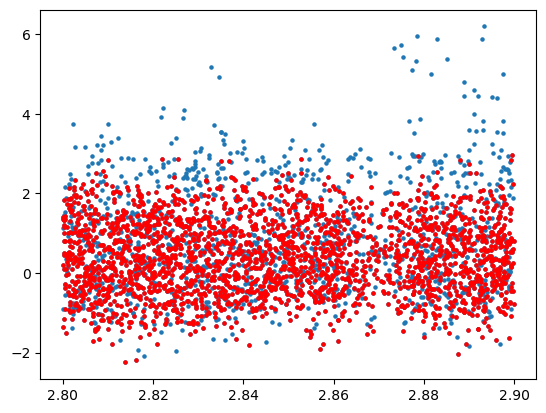

In [10]:
tgals = np.where((g.coords[:,2] >=2.8) & (g.coords[:,2] <= 2.9))
ggals = g.subpops['field2']


# plt.scatter(g.coords[:,2][tgals], g.pks[2.25][tgals], s=5 )
# plt.scatter(g.coords[:,2][ggals], g.pks[2.25][ggals], c='r', s=5)

plt.scatter(g.coords[:,2][tgals], g.n_sigmas[tgals], s=5 )
plt.scatter(g.coords[:,2][ggals], g.n_sigmas[ggals], c='r', s=5)

In [11]:
print(g.vols)

{'field1': 1115253.6813533937, 'field2': 1165440.100079306, 'field': array([False, False, False, ..., False, False, False]), 'o2.0': 231068.2426, 'o2.25': 74814.7761, 'o2.5': 50053.77, 'o3.0': 27358.5011, 'o3.5': 14440.186, 'o4.0': 8062.5517, 'o4.5': 4693.1332999999995, 'o5.0': 2939.2553, '23': 203709.7415, '34': 8672.5199}


Average Volume =  2281399.2842263263
[1130.0, 747.0, 512.0, 360.0, 265.0, 170.0, 75.0, 25.0, 3.0, 1.0]
3288.0


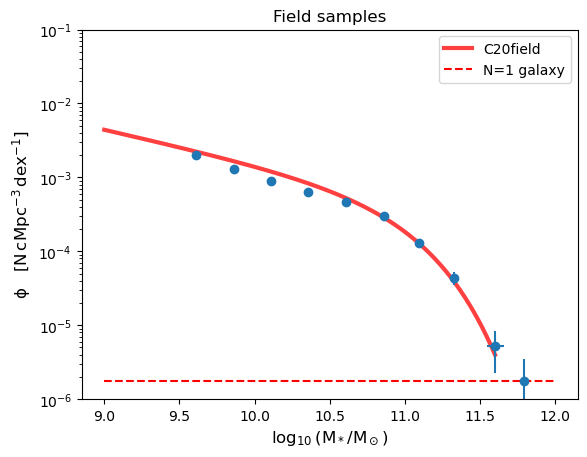

Average Volume =  74814.77610000003
[84.0, 61.0, 51.0, 26.0, 22.0, 16.0, 10.0, 2.0, 0.0, 0.0]
272.0


C:\Users\sikor\AppData\Local\Temp\ipykernel_11656\257525964.py:69: RuntimeWarning: Mean of empty slice
  plot_sfr.append(np.nanmean(ssfrs[:,i]))


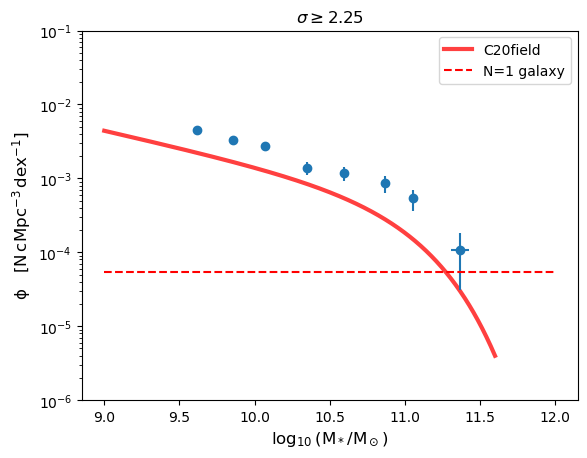

Average Volume =  50022.73698316831
[69.0, 49.0, 45.0, 21.0, 18.0, 14.0, 9.0, 1.0, 0.0, 0.0]
226.0


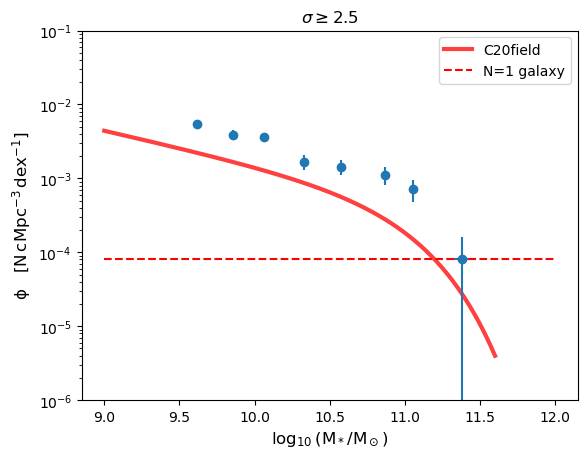

Average Volume =  2281399.2842263263
[43.0, 30.0, 33.0, 14.0, 15.0, 8.0, 7.0, 1.0, 0.0, 0.0]
151.0


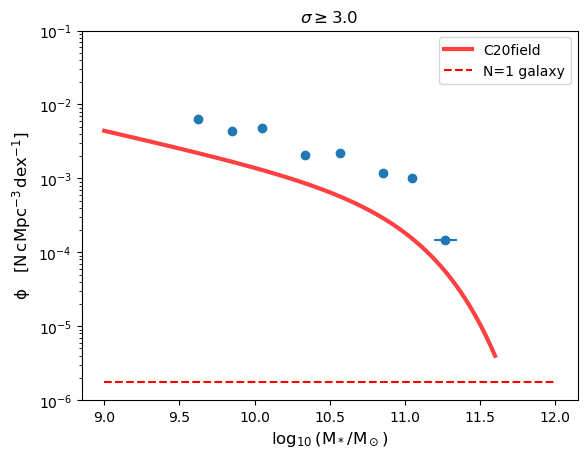

Average Volume =  8233.325592079205
[16.0, 13.0, 19.0, 6.0, 10.0, 4.0, 3.0, 0.0, 0.0, 0.0]
71.0


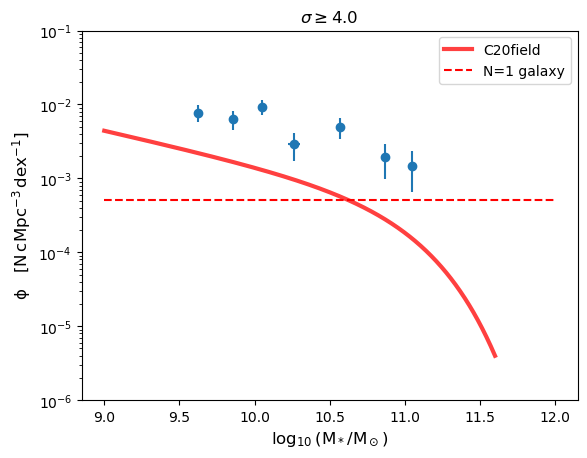

Average Volume =  203908.42159108914
[40.0, 30.0, 17.0, 11.0, 7.0, 8.0, 3.0, 1.0, 0.0, 0.0]
117.0


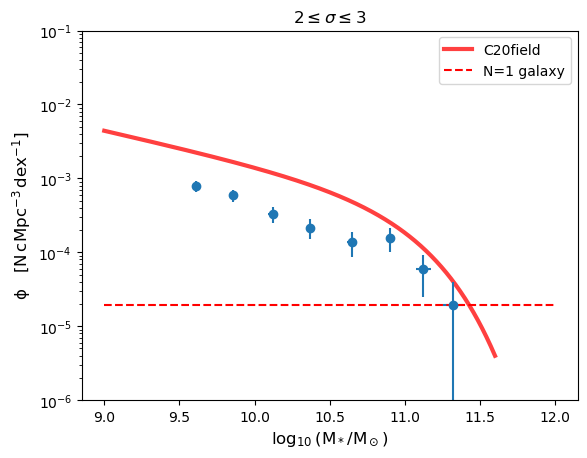

Average Volume =  8501.746007920792
[26.0, 16.0, 13.0, 8.0, 4.0, 4.0, 3.0, 0.0, 0.0, 0.0]
74.0


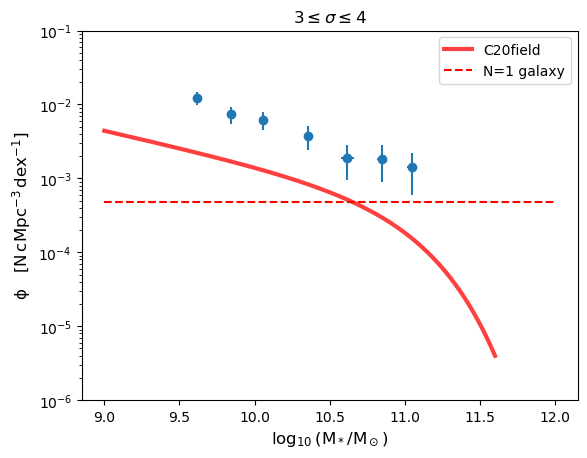

In [17]:
all_smfs = []

titles = ["Field samples", r"$\sigma \geq 2.25$", r"$\sigma \geq 2.5$", r"$\sigma \geq 3.0$", r"$\sigma \geq 4.0$",  
          r"$2 \leq \sigma \leq 3$", r"$3 \leq \sigma \leq 4$"]
for ki, key in enumerate(['field', 'o2.25', 'o2.5', 'o3.0', 'o4.0', '23', '34']):

    if ki in [3,6]:
        tot_ms  = np.zeros(shape=(len(gps), len(gps[0].smfs['o4.0'])))
        tot_ns = np.zeros(shape=(len(gps), len(gps[0].smfs['o4.0'])))
        tot_errs = np.zeros(shape=(len(gps), len(gps[0].smfs['o4.0'])))
        tot_Ns = np.zeros(shape=(len(gps), len(gps[0].smfs['o4.0'])))
        ssfrs = np.zeros(shape=(len(gps), len(gps[0].smfs['o4.0'])))

    else:
        tot_ms  = np.zeros(shape=(len(gps), len(gps[0].smfs['field'])))
        tot_ns = np.zeros(shape=(len(gps), len(gps[0].smfs['field'])))
        tot_errs = np.zeros(shape=(len(gps), len(gps[0].smfs['field'])))
        tot_Ns = np.zeros(shape=(len(gps), len(gps[0].smfs['field'])))
        ssfrs = np.zeros(shape=(len(gps), len(gps[0].smfs['field'])))

    vols = []


    for idx, t in enumerate(gps):


        if ki in [0,3]:

            tot_ms[idx]  = t.smfs[key][:,0]
            tot_errs[idx] = t.smfs[key][:,3]
            tot_Ns[idx] = t.smfs[key][:,1]
            tot_ns[idx] = t.smfs[key][:,2]
            vols.append(t.vols['field1'] + t.vols['field2'])

            ssfrs[idx] = t.smfs[key][:,4]



        else: 

            tot_ms[idx]  = gps[idx].smfs[key][:,0]
            tot_errs[idx] = gps[idx].smfs[key][:,3]
            tot_Ns[idx] = gps[idx].smfs[key][:,1]

            tot_ns[idx] = gps[idx].smfs[key][:,2]
            vols.append(gps[idx].vols[key])

            ssfrs[idx] = gps[idx].smfs[key][:,4]


    print("Average Volume = ", np.mean(vols))
    plot_m = []
    plot_n = []
    yerror = []
    xerror = []
    m_counts = []
    plot_sfr = []
    plot_qf = []
    plot_Ns = []
    for i in range(tot_ms.shape[1]):
        plot_m.append(np.nanmedian(tot_ms[:,i]))
        xerror.append(np.std(tot_ms[:,i]))
        plot_n.append(np.median(tot_ns[:,i]))
        plot_Ns.append(np.nanmedian(tot_Ns[:,i]))

        p_err = np.sqrt(np.nanmedian(tot_Ns[:,i])) / np.median(vols) / 0.25
        yerror.append(  nmad(tot_ns[:,i])**2 + p_err)

        plot_sfr.append(np.nanmean(ssfrs[:,i]))
        qgs = np.where(ssfrs[:,i] < 10**-11)[0]
        plot_qf.append(len(qgs)/len(ssfrs[:,i]))

        mc = len(tot_ns) - len(tot_ns[np.isnan(tot_ns[:,i])])
        
        m_counts.append(mc)

        if i == (tot_ms.shape[1] -1):
            print(plot_Ns)
            print(sum(plot_Ns))
    
    temp = np.c_[plot_m, plot_n, yerror, xerror, plot_sfr, plot_qf, plot_Ns]
    all_smfs.append(temp)
    xbin = np.linspace(9, 12, 25)
    ybin = np.logspace(-6, -1, 25)

    fig, ax = plt.subplots()
    ms = np.linspace(9, 11.6, 1000)
    ax.plot(ms, C20field(ms, 1), color='red', lw='3', alpha=0.75, label="C20field")

    ax.errorbar(plot_m, plot_n,yerr=yerror, xerr=xerror, marker='o', ls="")
    # Plot the 2D histogram again with the discrete norm 
    ax.set(yscale='log', ylim=(1e-6, 1e-1), title=titles[ki])
    ax.set_ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize=12)
    ax.set_xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=12)
    ax.hlines(y=1/np.min(vols)/0.25, xmin=9, xmax=12, color='r', ls='dashed', label="N=1 galaxy")
    ax.legend(loc="upper right")

    plt.show()

all_smfs = np.array(all_smfs)

Field
$n_\sigma \geq 2.25$
$n_\sigma \geq 2.5$
$n_\sigma \geq 3$
$n_\sigma \geq 4$

10.89 0.29
0.1 0.05

10.98 0.64
0.17 0.15

11.01 0.75
0.22 0.22

10.97 0.96
0.17 0.23

11.22 1.05
0.47 0.55


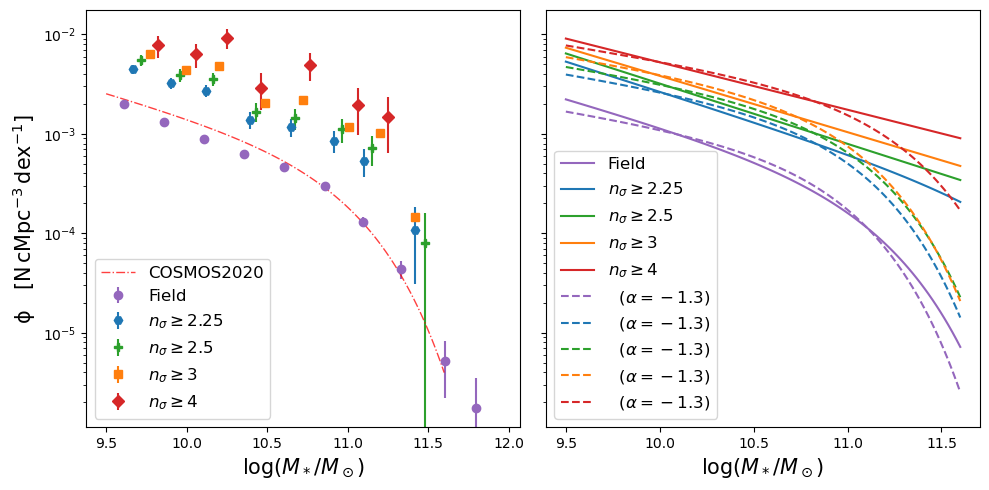

In [24]:
from scipy.optimize import curve_fit


### Plot all smfs ###
colors = ['tab:purple', 'tab:blue','tab:green', 'tab:orange', 'tab:red']  
shapes = ["o", "H", "P", "s", "D", (5,1,0)]
labels = ['Field', r'$n_\sigma \geq 2.25$', r'$n_\sigma \geq 2.5$', r'$n_\sigma \geq 3$', r'$n_\sigma \geq 4$']
fig, axs = plt.subplots(1,2, sharey=True)
fig.set_size_inches(10, 5)

ms = np.linspace(9.5, 11.6, 100)

for i, s in enumerate(all_smfs[:5]):
    
    axs[0].errorbar(s[:,0]+0.05*i, s[:,1], yerr=s[:,2], ls='',marker=shapes[i], color=colors[i], label=labels[i])
    # axs[0].plot(s[1:][:,0]+0.05*i, s[1:][:,1], ls='',marker=shapes[i], color=colors[i], label=labels[i])
    last = np.where(s[:,1] ==0)[0]

    if len(last) != 0: last_i = last[0] -1
    else: last_i = len(s)

    print(labels[i])
    f_params, f_err = curve_fit(schechter, s[:,0][:last_i], s[:,1][:last_i], sigma=s[ :,-1][:last_i],
                                  p0=[0.5, -1, 11], maxfev=2000)
    axs[1].plot(ms, schechter(ms, *f_params),color=colors[i], label=labels[i])



    # print(round(f_params[2], 2),round(f_params[1], 2), round(f_params[0]/10**-3, 2))
    # print(round(np.sqrt(f_err[2,2]),2),round( np.sqrt(f_err[1,1]),2),round( np.sqrt(f_err[0,0])/10**-3,2))
    # print()


for i, s in enumerate(all_smfs[:-2]):

    f_params, f_err = curve_fit(fschechter, s[:,0][:last_i], s[:,1][:last_i], sigma=s[:,-1][:last_i],
                                  p0=[0.5, 11], maxfev=2000)
    axs[1].plot(ms, fschechter(ms, *f_params),color=colors[i], label= r'  ($\alpha=-1.3$)',ls='--' )
    print()
    print(round(f_params[1], 2), round(f_params[0]/10**-3, 2))
    print(round( np.sqrt(f_err[1,1]),2),round( np.sqrt(f_err[0,0])/10**-3,2))



axs[0].plot(ms, C20field(ms, 1), color='red', lw='1', ls='dashdot', alpha=0.75, label="COSMOS2020")

axs[0].set(yscale='log')
axs[0].set_xlabel(r'$\log(M_*/M_\odot)$', fontsize = 15)
axs[0].set_ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize = 15)
axs[0].legend(loc='lower left', fontsize=12) 

axs[1].set(yscale='log')
axs[1].set_xlabel(r'$\log(M_*/M_\odot)$', fontsize = 15)
axs[1].legend(loc='lower left', ncols=1, fontsize=12)

plt.tight_layout()
plt.show()

(101, 10)
10 10
(101, 10)
10 10
(101, 10)
10 10
(101, 10)
10 10


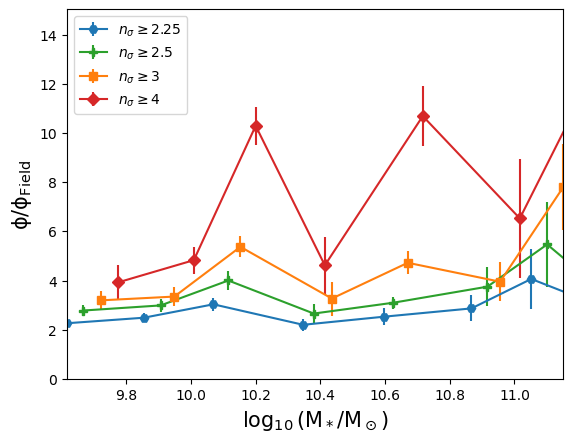

In [27]:
colors = ['tab:purple', 'tab:blue','tab:green', 'tab:orange', 'tab:red']  
shapes = ["o", "H", "P", "s", "D", (5,1,0)]
labels = ['Field', r'$n_\sigma \geq 2.25$', r'$n_\sigma \geq 2.5$', r'$n_\sigma \geq 3$', r'$n_\sigma \geq 4$']
min_m, max_m = 99, -99  # For plot limits
min_n, max_n = 0.2, 1


for ki, key in enumerate(['o2.25', 'o2.5', 'o3.0', 'o4.0']):
    norms = all_smfs[0][:,1]
    # if ki != 2: norms = all_smfs[0][:,1]
    # else: norms = all_smfs[-1][:,1]

    tot_ns = np.zeros(shape=(len(gps), len(gps[0].smfs[key])))
    tot_errs = np.zeros(shape=(len(gps), len(gps[0].smfs[key])))

    for idxs, t in enumerate(gps):

            tot_ns[idxs] = gps[idxs].smfs[key][:,2]

    print(tot_ns.shape)
    data = all_smfs[ki+1]
    # Set length of normalizing array
    print(len(norms), len(data))
    if len(norms) > len(data): 
        norms = norms[:len(data)]   # Shorten normalizing array
    else:   # Shorten data
        data = data[:len(norms)]

    plot_err = []
    for i in range(len(gps[0].smfs[key])):
        ye = tot_ns[:,i]/norms[i]
        plot_err.append(nmad(ye))

    last = np.where(data[:,1] ==0)[0]

    if len(last) != 0: last_i = last[0]
    else: last_i = len(data)


    plt.errorbar(data[:,0][:last_i]+0.05*ki, data[:,1][:last_i] / norms[:last_i], yerr= plot_err[:last_i], 
                    label=labels[ki+1], marker=shapes[ki+1], color=colors[ki+1])

    # fp, fe = curve_fit(linear, data[:,0][:last_i], data[:,1][:last_i] / norms[:last_i], sigma=plot_err[:last_i] , maxfev=1000)
    
    
    min_m = min(min_m, min(data[:,0]))
    max_m = max(max_m, max(data[:,0]))
    min_n = min(min_n, min(data[:,1]/norms))
    max_n = max(max_n, max(data[:,1]/norms))

    ms = np.linspace(min_m, max_m, 10)
    # print(fp)
    # plt.plot(ms+0.05*ki, linear(ms, *fp), c=colors[ki+1], ls='--')


plt.legend(loc='upper left')

plt.ylabel(r"$\rm \phi/\phi_{Field}$", fontsize=15)
plt.xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=15)    
plt.xlim(min_m, 11.15)
plt.ylim(min_n, max_n+ 3.7)


plt.show()
